In [1]:
from utils.config import experiments_path, simulations_path
from models.patternsdb import patternsDB, patternsDB_npz_abg
import numpy as np
import os
from torch.utils.data import DataLoader
import torch
from torch import nn
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from utils.etl_utils import get_geometry_settings

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
simulation_ids = []
experiment_path = experiments_path + 'experiment000032'
with open(experiment_path) as experiment:
    for i, line in enumerate(experiment.readlines()):
        if i == 0:
            print(line)
        else:
            simulation_ids.append(line.split()[0])

This is a clean version of experiment 30. Building training set, randomly selecting from DE thickness 1, 1.5, 2 nm - FE thickness between 1 nm and 10 nm in steps of 0.5. - alpha, beta, gamma with theta parameter - g11=g44 from 1e-12 to 1e-9. 100 simulations



0 simulation001842 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.4e-08])
1 simulation001849 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.45e-08])
2 simulation001857 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.55e-08])
3 simulation001875 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.75e-08])
4 simulation001880 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.2e-08])
5 simulation001883 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.9e-08])
6 simulation001893 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.2e-08])
7 simulation001904 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.2e-08])
8 simulation001905 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.4e-08])
9 simulation001906 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.6e-08])
10 simulation001929 ([-1.6e-08, -1.6e-08, 1.1e-08], [1.6e-08, 1.6e-08, 1.4e-08])


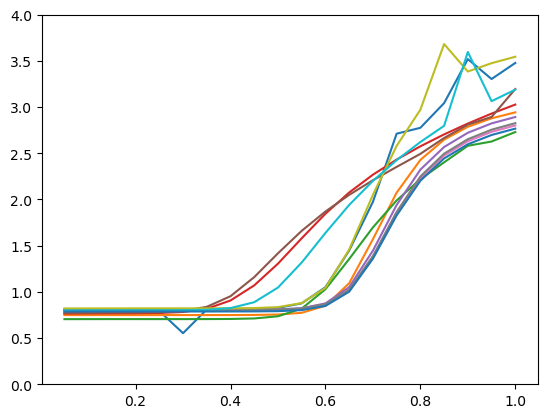

In [3]:
count = 0
for simulation_id in simulation_ids:
    data = patternsDB(simulations_path, *[simulation_id + '/'])
    capacitance_series = data.capacitance_series.mul(100)
    if len(capacitance_series) > 0:
        if np.max(capacitance_series.values) > 2.5:
            print(count, simulation_id, get_geometry_settings(simulations_path+simulation_id+'/'))
            #print()
            capacitance_series.plot(ylim=(0,4))
            count = count + 1


In [4]:
selected_ml_simulation_ids_and_ts = []
for simulation_id in simulation_ids:
    entry_names = []
    simulation_path = simulations_path + simulation_id + '/'
    for entry in os.scandir(simulation_path):
        if entry.is_file() and 'npz0' in entry.name:
            entry_names.append((simulation_id, entry.name))
    if 2 >= len(entry_names): continue
    selected_ml_simulation_ids_and_ts.extend(entry_names[1:])

In [5]:
len(selected_ml_simulation_ids_and_ts)

1860

In [6]:
test_size = 0.20
train_or_test = np.random.rand(len(selected_ml_simulation_ids_and_ts))

train_ml_simulation_ids_and_ts_dict = {}
test_ml_simulation_ids_and_ts_dict = {}
for i in range(len(selected_ml_simulation_ids_and_ts)):
    if train_or_test[i] > test_size:
        if selected_ml_simulation_ids_and_ts[i][0] + '/' not in train_ml_simulation_ids_and_ts_dict.keys():
            train_ml_simulation_ids_and_ts_dict[selected_ml_simulation_ids_and_ts[i][0] + '/' ] = [selected_ml_simulation_ids_and_ts[i][1]]
        else:
            train_ml_simulation_ids_and_ts_dict[selected_ml_simulation_ids_and_ts[i][0]+ '/' ].append(selected_ml_simulation_ids_and_ts[i][1])
    else:
        if selected_ml_simulation_ids_and_ts[i][0] + '/' not in test_ml_simulation_ids_and_ts_dict.keys():
            test_ml_simulation_ids_and_ts_dict[selected_ml_simulation_ids_and_ts[i][0]+ '/' ] = [selected_ml_simulation_ids_and_ts[i][1]]
        else:
            test_ml_simulation_ids_and_ts_dict[selected_ml_simulation_ids_and_ts[i][0]+ '/' ].append(selected_ml_simulation_ids_and_ts[i][1])

In [7]:
train_npz_list = []
for simulation_id in train_ml_simulation_ids_and_ts_dict.keys():
    train_npz_str = ''.join(simulation_id)
    for npz in train_ml_simulation_ids_and_ts_dict[simulation_id]:
        train_npz_list.append(train_npz_str + npz)

In [8]:
test_npz_list = []
for simulation_id in test_ml_simulation_ids_and_ts_dict.keys():
    test_npz_str = ''.join(simulation_id)
    for npz in test_ml_simulation_ids_and_ts_dict[simulation_id]:
        test_npz_list.append(test_npz_str + npz)

In [9]:
print(len(train_npz_list))
print(len(test_npz_list))
print(len(train_npz_list)+len(test_npz_list))

1491
369
1860


In [10]:
training_data = patternsDB_npz_abg(simulations_path, *train_npz_list)
test_data = patternsDB_npz_abg(simulations_path, *test_npz_list)

In [11]:
print(len(training_data))
print(len(test_data))

1491
369


In [12]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

model_1
epoch: 0 loss: 0.380436509847641
epoch: 100 loss: 0.06304799020290375
epoch: 200 loss: 0.013856404460966587
epoch: 300 loss: 0.015042209066450596
epoch: 400 loss: 0.009811888448894024
epoch: 500 loss: 0.009588570334017277
epoch: 600 loss: 0.02508879266679287
epoch: 700 loss: 0.035034336149692535
epoch: 800 loss: 0.0024420612026005983
epoch: 900 loss: 0.013584467582404613
epoch: 1000 loss: 0.003873978042975068


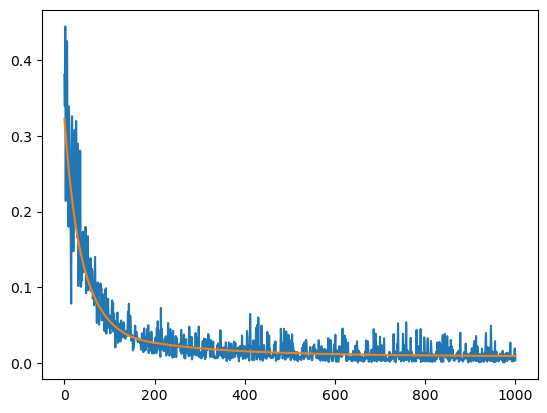

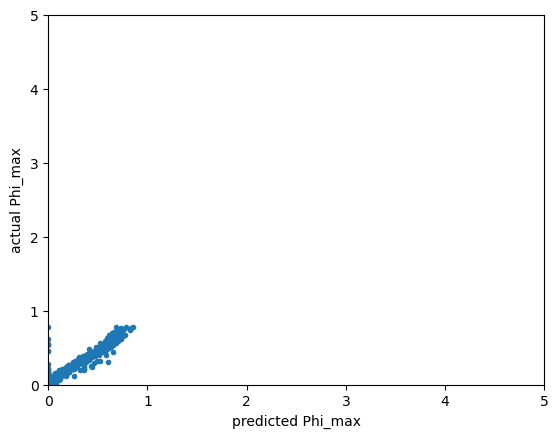

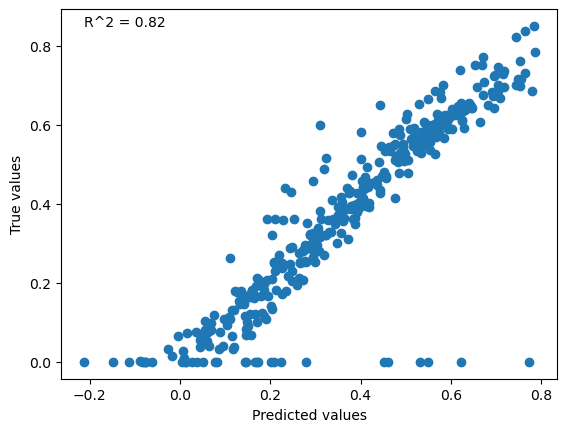

model_2
epoch: 0 loss: 0.20445041358470917
epoch: 100 loss: 0.011885617859661579
epoch: 200 loss: 0.018478693440556526
epoch: 300 loss: 0.02555946074426174
epoch: 400 loss: 0.0012625530362129211
epoch: 500 loss: 0.02939458191394806
epoch: 600 loss: 0.0017728378297761083
epoch: 700 loss: 0.0029963795095682144
epoch: 800 loss: 0.01298774778842926
epoch: 900 loss: 0.0007096591289155185
epoch: 1000 loss: 0.017355667427182198


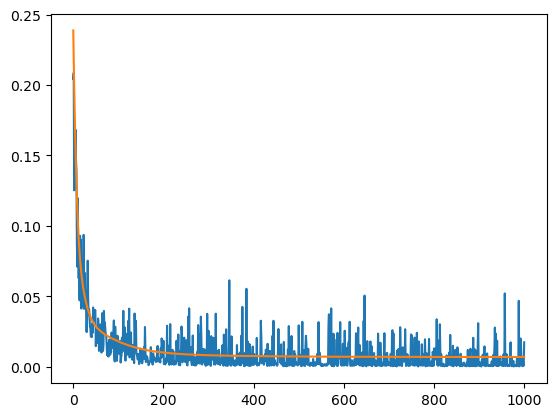

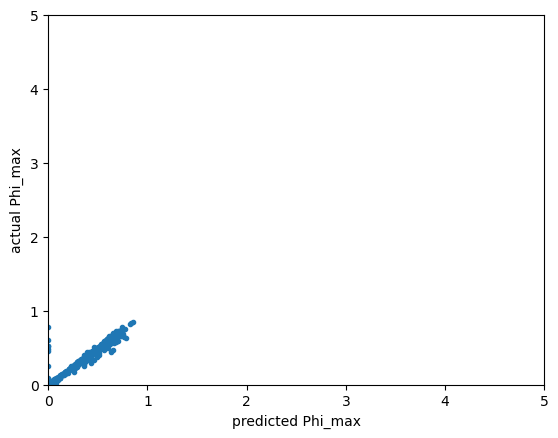

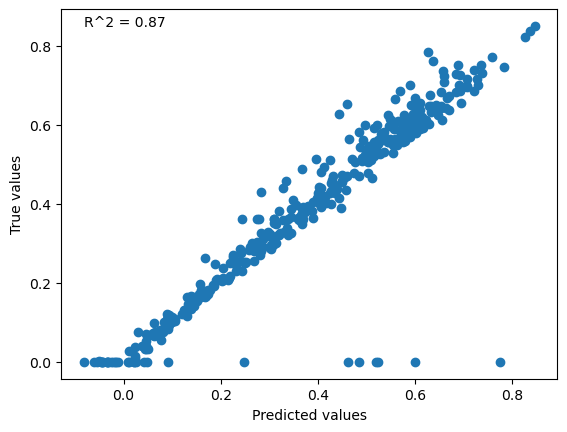

model_3
epoch: 0 loss: 0.1855069100856781
epoch: 100 loss: 0.005262524820864201
epoch: 200 loss: 0.0060258544981479645
epoch: 300 loss: 0.005657627247273922
epoch: 400 loss: 0.0009804657893255353
epoch: 500 loss: 0.002393771195784211
epoch: 600 loss: 0.008073052391409874
epoch: 700 loss: 0.0009970919927582145
epoch: 800 loss: 0.019433511421084404
epoch: 900 loss: 0.0007756690611131489
epoch: 1000 loss: 0.0009787973249331117


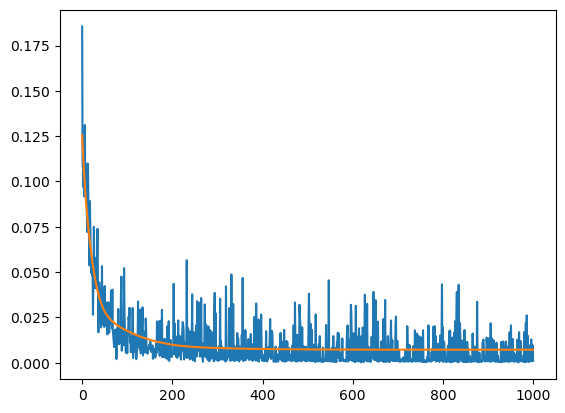

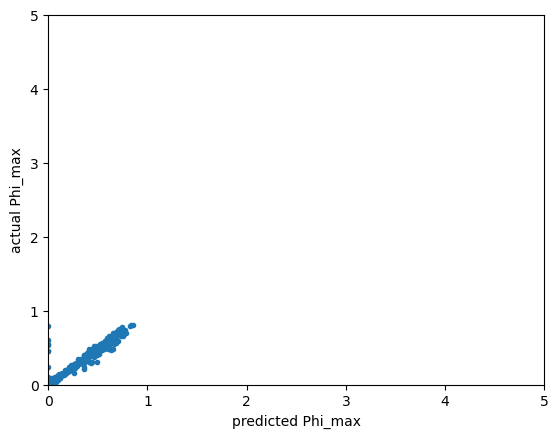

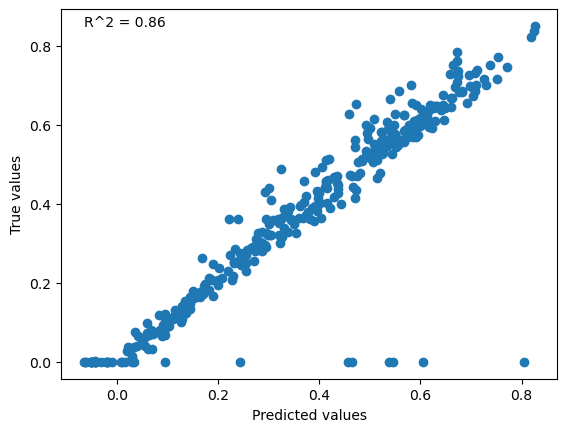

model_1
epoch: 0 loss: 0.22290776669979095
epoch: 100 loss: 0.02339722216129303
epoch: 200 loss: 0.017365697771310806
epoch: 300 loss: 0.008186966180801392
epoch: 400 loss: 0.0009092109394259751
epoch: 500 loss: 0.005488378461450338
epoch: 600 loss: 0.00966999214142561
epoch: 700 loss: 0.0023047083523124456
epoch: 800 loss: 0.011562814004719257
epoch: 900 loss: 0.017977386713027954
epoch: 1000 loss: 0.020346883684396744


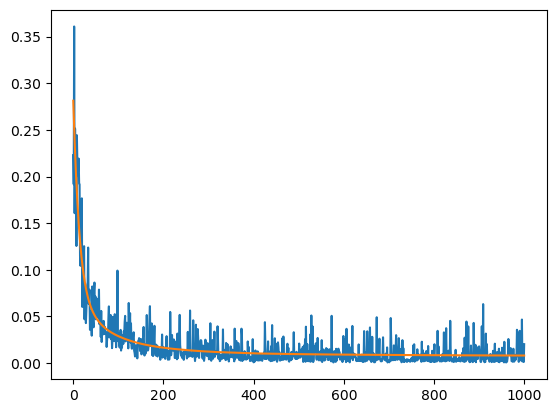

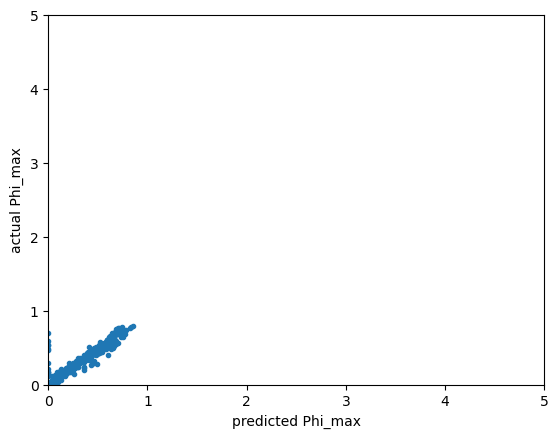

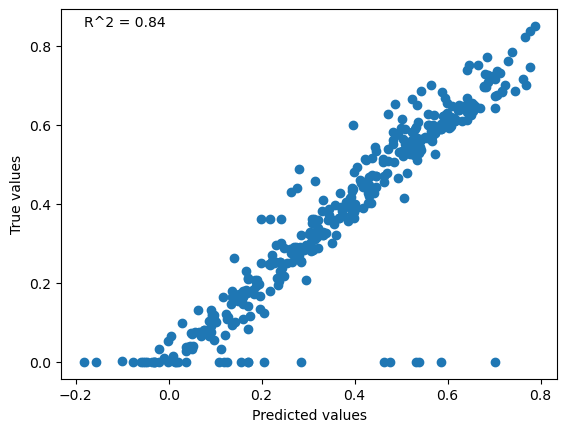

model_2
epoch: 0 loss: 0.1582319289445877
epoch: 100 loss: 0.0064951651729643345
epoch: 200 loss: 0.0016677173553034663
epoch: 300 loss: 0.0005925376317463815
epoch: 400 loss: 0.0011753819417208433
epoch: 500 loss: 0.003689252305775881
epoch: 600 loss: 0.0005987550830468535
epoch: 700 loss: 0.010454549454152584
epoch: 800 loss: 0.009503671899437904
epoch: 900 loss: 0.00012765130668412894
epoch: 1000 loss: 0.0011315334122627974


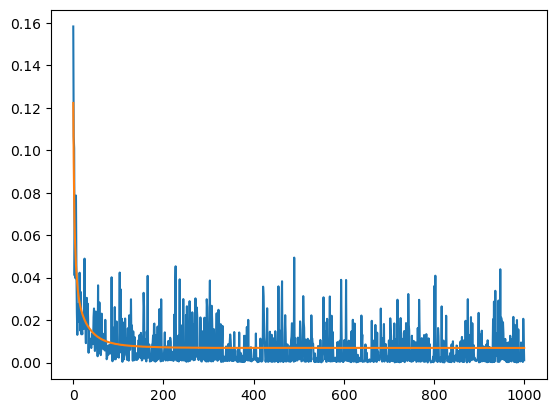

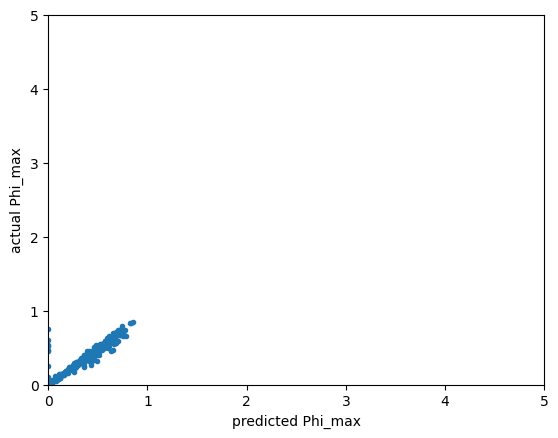

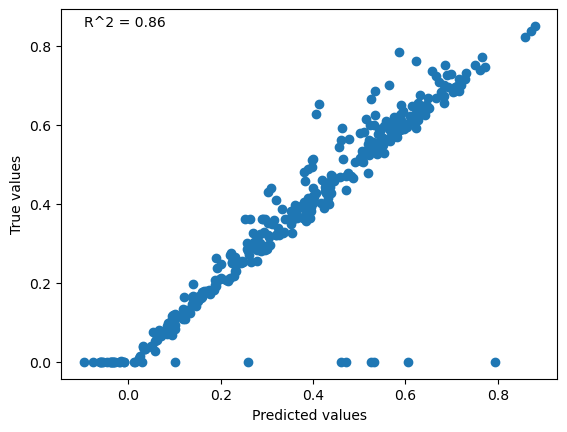

model_3
epoch: 0 loss: 0.10621327906847
epoch: 100 loss: 0.014676406048238277
epoch: 200 loss: 0.009883258491754532
epoch: 300 loss: 0.0133897066116333
epoch: 400 loss: 0.002539054024964571
epoch: 500 loss: 0.008421206846833229
epoch: 600 loss: 0.021656494587659836
epoch: 700 loss: 0.013285098597407341
epoch: 800 loss: 0.00041574391070753336
epoch: 900 loss: 0.0006657507037743926
epoch: 1000 loss: 0.0010145542910322547


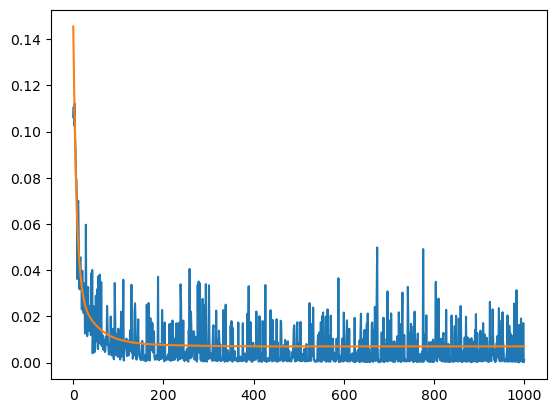

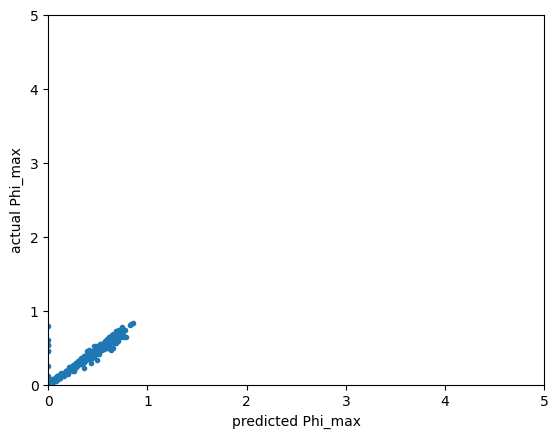

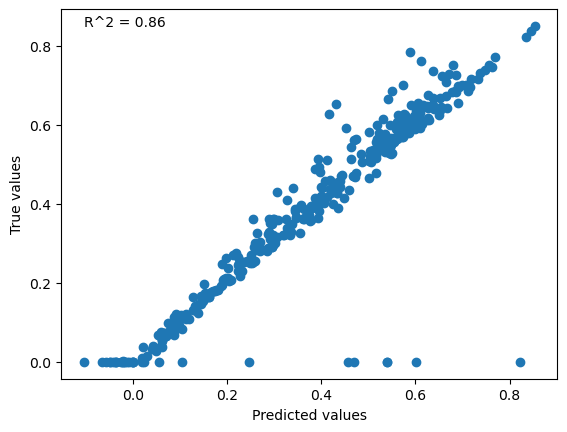

In [13]:
neurons_per_layer_list = [128, 256]
df_dict = {}
epochs = 1001
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
for neurons_per_layer in neurons_per_layer_list:
    #models = [net_1(3,1,neurons_per_layer), net_2(3,1,neurons_per_layer), net_3(3,1,neurons_per_layer), net_4(3,1,neurons_per_layer)]
    
    models = [torch.nn.Sequential(torch.nn.Linear(7, neurons_per_layer), 
                                  torch.nn.ReLU(), 
                                  torch.nn.Linear(neurons_per_layer, 1)),
              
              torch.nn.Sequential(torch.nn.Linear(7, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, 1)),
              
              torch.nn.Sequential(torch.nn.Linear(7, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, int(neurons_per_layer/2)),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(int(neurons_per_layer/2), int(neurons_per_layer/4)),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(int(neurons_per_layer/4), 1))
    ]
             
    
    mses = []
    index = []
    for j, model in enumerate(models, 1):
        print('model_'+str(j))
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
        #optimizer = torch.optim.LBFGS(model.parameters())
        
        
        costval = []
        epoch_list = []
        
        # Hold the best model
        best_mse = np.inf   # init to infinity
        best_weights = None
        history = []
        
        for epoch in range(epochs):
            model.train()
            for i,(x_train, y_train) in enumerate(train_dataloader):
                
                
                #prediction
                y_pred = model(x_train)
                y_train = y_train.reshape(-1,1)

                #calculating loss
                loss = loss_fn(y_pred, y_train)

                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if epoch%100 == 0:
                print('epoch:', epoch, 'loss:', loss.item())
            costval.append(loss.item())
            epoch_list.append(epoch)
            
            model.eval()
            all_preds = []
            all_targets = []
            test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
            for i,(x_test, y_test) in enumerate(test_dataloader):
                y_pred = model(x_test)
                y_test = y_test.reshape(-1,1)
                mse = loss_fn(y_pred, y_test)
                
                if mse < best_mse:
                    best_mse = mse
                    best_weights = copy.deepcopy(model.state_dict())
                    best_y_test_actual = y_test.reshape(1,-1).detach().numpy()[0]
                    best_y_test_pred = y_pred.reshape(1,-1).detach().numpy()[0]
                    
                all_preds.append(y_pred)
                all_targets.append(y_test)
                    
            history.append(best_mse.item())
                
        pd.Series(costval, index=epoch_list).plot()
        
        pd.Series(history, index=epoch_list).plot()
        plt.show()
        
        pd.Series(best_y_test_pred, index=best_y_test_actual).plot(style='.', xlim=(0,5), ylim=(0,5), xlabel="predicted Phi_max", ylabel="actual Phi_max")
        plt.show()
        
                
        # Convert all_preds and all_targets to a single tensor
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        # Compute R^2 Score
        r2 = r2_score(all_targets.detach().numpy(), all_preds.detach().numpy())

        # Plotting the predicted vs true values
        plt.scatter(all_preds.detach().numpy(), all_targets.detach().numpy())
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        # plt.title('Predicted vs True values')
        # Adding R^2 text
        plt.text(min(all_preds.detach().numpy()), max(all_targets.detach().numpy()), f'R^2 = {r2:.2f}')
        # Save the figure
        #plt.savefig("predicted_vs_true.jpg")
        plt.show()

    del(model)

model_1 Neurons: 8
epoch: 0 loss: 0.10331042855978012
epoch: 100 loss: 0.047934602946043015
epoch: 200 loss: 0.06132166460156441
epoch: 300 loss: 0.04438268020749092
epoch: 400 loss: 0.03342908248305321
epoch: 500 loss: 0.03766271844506264
epoch: 600 loss: 0.031060921028256416
epoch: 700 loss: 0.013238304294645786
epoch: 800 loss: 0.01198428776115179
epoch: 900 loss: 0.022462600842118263
epoch: 1000 loss: 0.016615087166428566


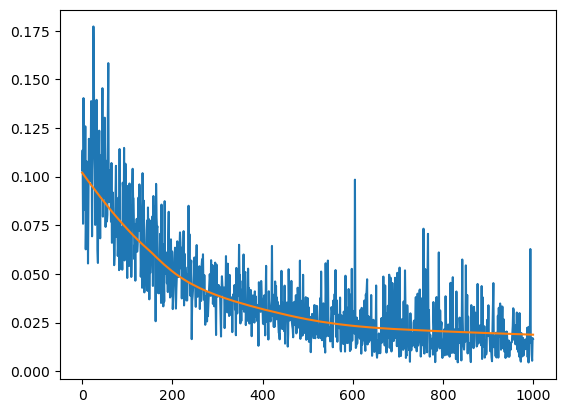

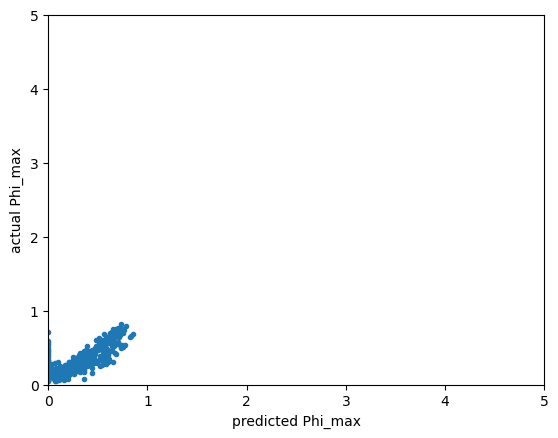

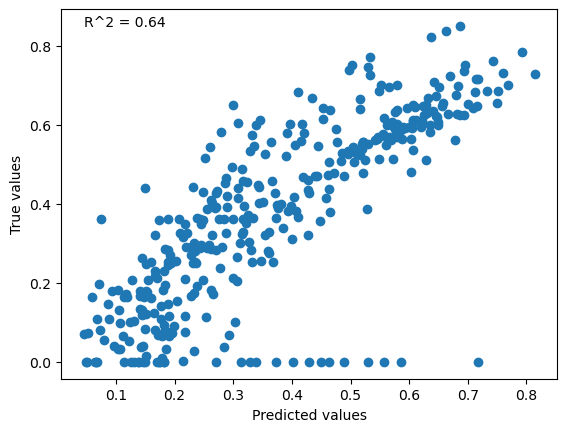

model_2 Neurons: 8
epoch: 0 loss: 0.19221171736717224
epoch: 100 loss: 0.1615723818540573
epoch: 200 loss: 0.07323531061410904
epoch: 300 loss: 0.04685679450631142
epoch: 400 loss: 0.04307616874575615
epoch: 500 loss: 0.028705831617116928
epoch: 600 loss: 0.04660237953066826
epoch: 700 loss: 0.04161078855395317
epoch: 800 loss: 0.03798377513885498
epoch: 900 loss: 0.021847987547516823
epoch: 1000 loss: 0.042883794754743576


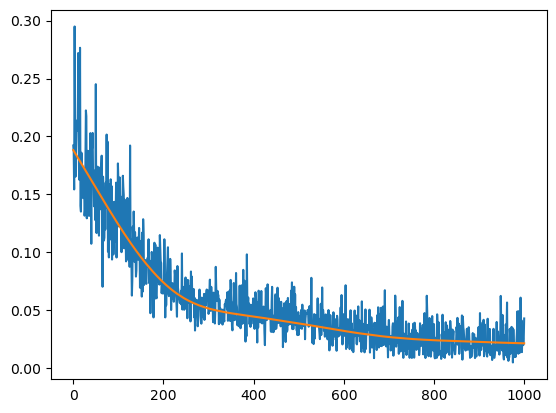

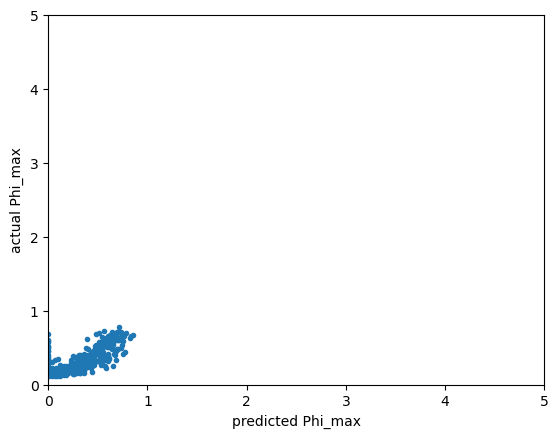

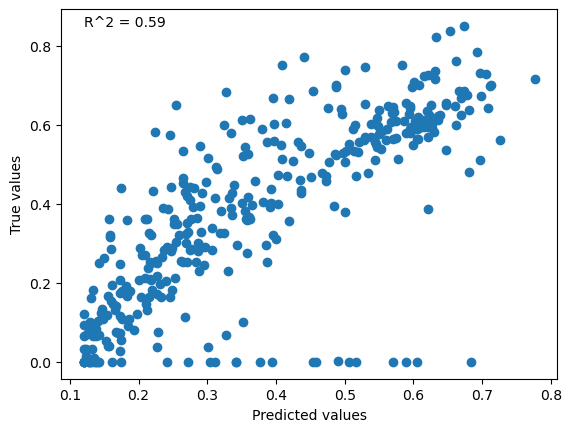

model_1 Neurons: 16
epoch: 0 loss: 0.20368070900440216
epoch: 100 loss: 0.1666155904531479
epoch: 200 loss: 0.11400613933801651
epoch: 300 loss: 0.049792513251304626
epoch: 400 loss: 0.049784451723098755
epoch: 500 loss: 0.04124803841114044
epoch: 600 loss: 0.018861012533307076
epoch: 700 loss: 0.011321574449539185
epoch: 800 loss: 0.007788192480802536
epoch: 900 loss: 0.004847920499742031
epoch: 1000 loss: 0.007850000634789467


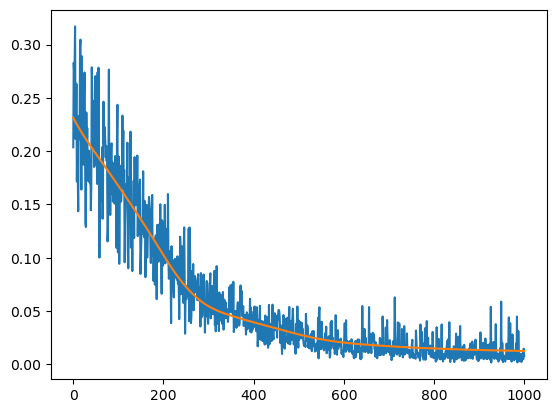

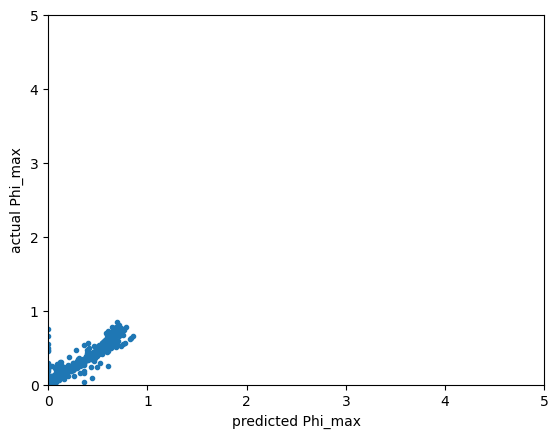

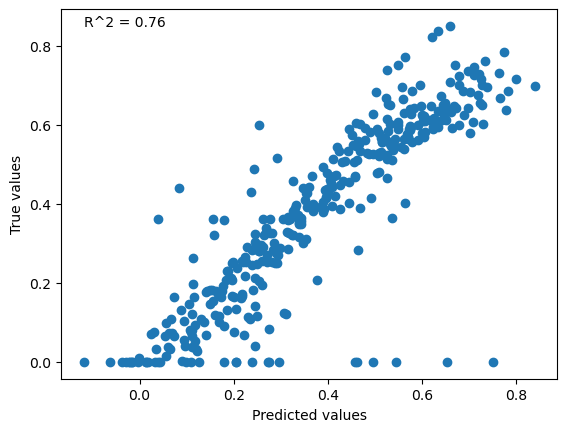

model_2 Neurons: 16
epoch: 0 loss: 0.2638058364391327
epoch: 100 loss: 0.15827594697475433
epoch: 200 loss: 0.09446343034505844
epoch: 300 loss: 0.06497539579868317
epoch: 400 loss: 0.03708721324801445
epoch: 500 loss: 0.01983359269797802
epoch: 600 loss: 0.027748700231313705
epoch: 700 loss: 0.01190162356942892
epoch: 800 loss: 0.012884932570159435
epoch: 900 loss: 0.007690642029047012
epoch: 1000 loss: 0.007401169743388891


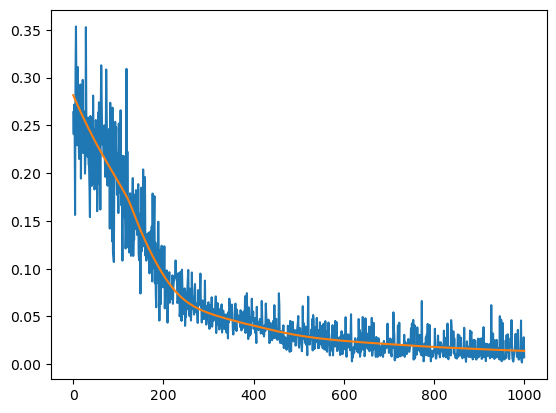

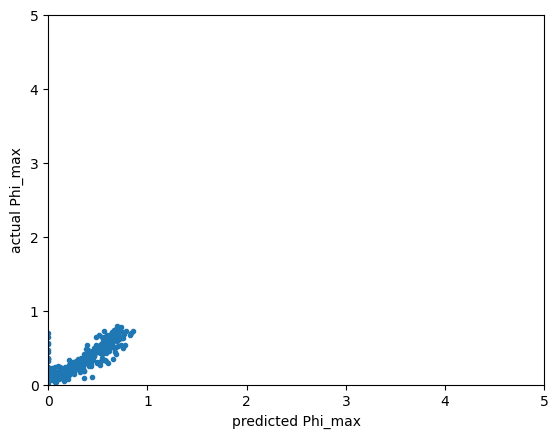

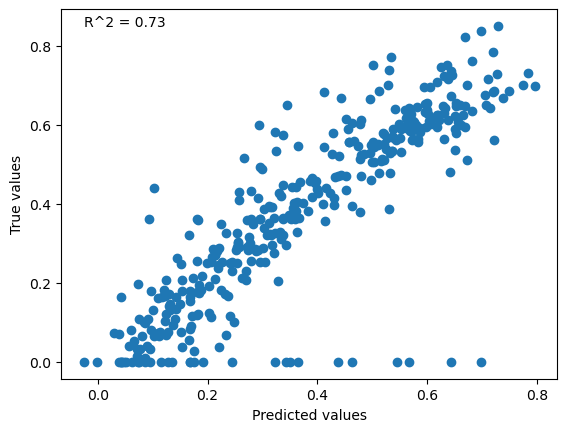

model_1 Neurons: 32
epoch: 0 loss: 0.4032524526119232
epoch: 100 loss: 0.07333194464445114
epoch: 200 loss: 0.04802011325955391
epoch: 300 loss: 0.03493677079677582
epoch: 400 loss: 0.004962925333529711
epoch: 500 loss: 0.005669222678989172
epoch: 600 loss: 0.015865014865994453
epoch: 700 loss: 0.012244573794305325
epoch: 800 loss: 0.0034859799779951572
epoch: 900 loss: 0.001947043347172439
epoch: 1000 loss: 0.010860186070203781


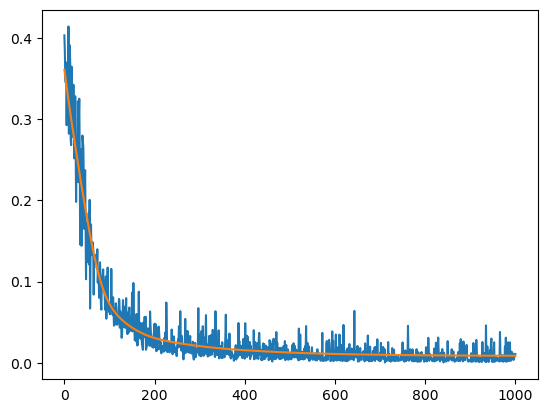

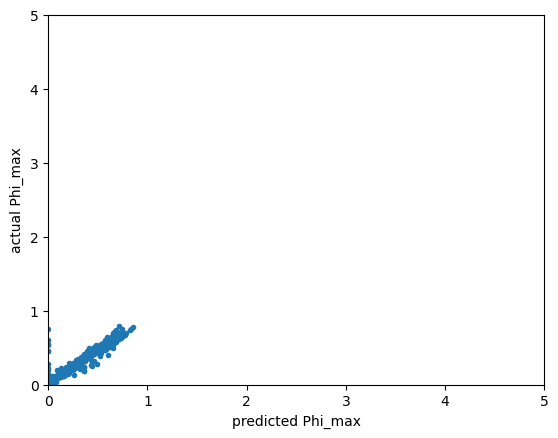

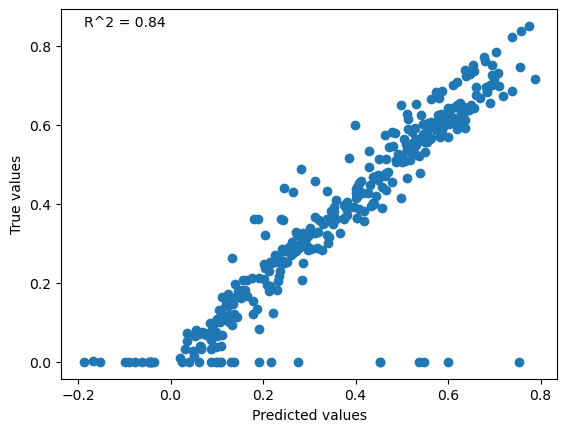

model_2 Neurons: 32
epoch: 0 loss: 0.14105431735515594
epoch: 100 loss: 0.039740968495607376
epoch: 200 loss: 0.025681937113404274
epoch: 300 loss: 0.007410472724586725
epoch: 400 loss: 0.009172199293971062
epoch: 500 loss: 0.0012170380214229226
epoch: 600 loss: 0.002222909824922681
epoch: 700 loss: 0.0013164320262148976
epoch: 800 loss: 0.001667586388066411
epoch: 900 loss: 0.0010216830996796489
epoch: 1000 loss: 0.0009004879393614829


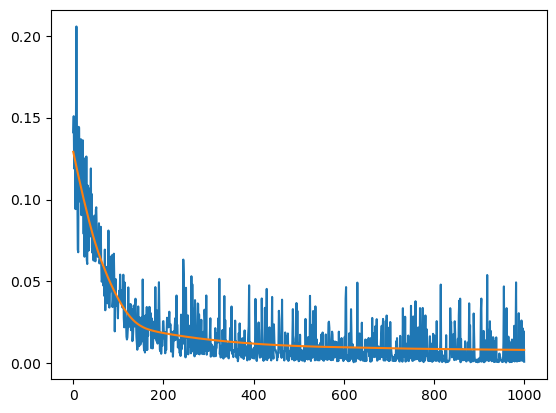

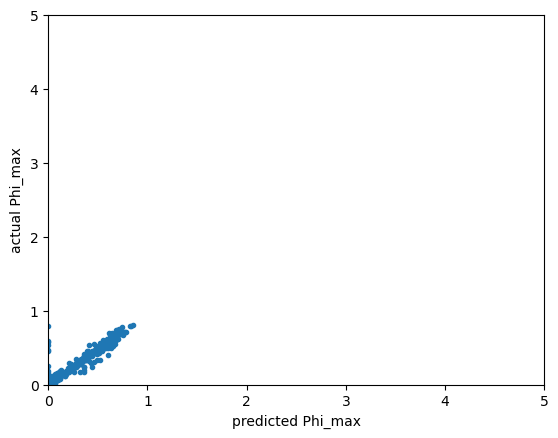

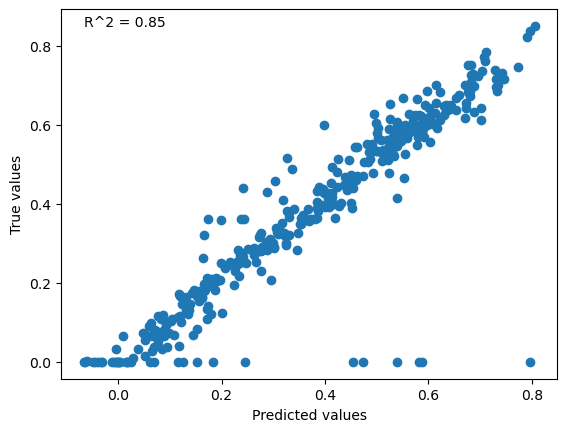

model_1 Neurons: 64
epoch: 0 loss: 0.10501768440008163
epoch: 100 loss: 0.0076623340137302876
epoch: 200 loss: 0.00296462862752378
epoch: 300 loss: 0.002791225677356124
epoch: 400 loss: 0.0006156632443889976
epoch: 500 loss: 0.0009100520401261747
epoch: 600 loss: 0.0013866391964256763
epoch: 700 loss: 0.0010782508179545403
epoch: 800 loss: 0.0009969212114810944
epoch: 900 loss: 0.029175231233239174
epoch: 1000 loss: 0.0046464381739497185


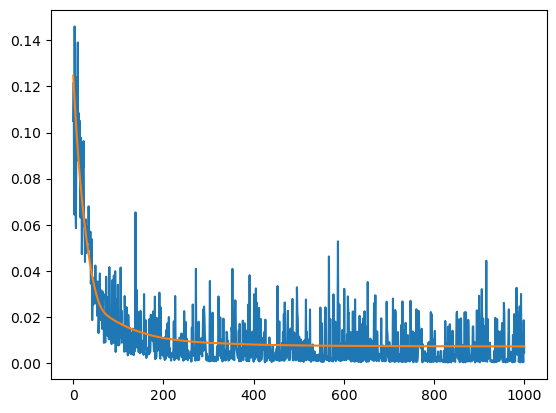

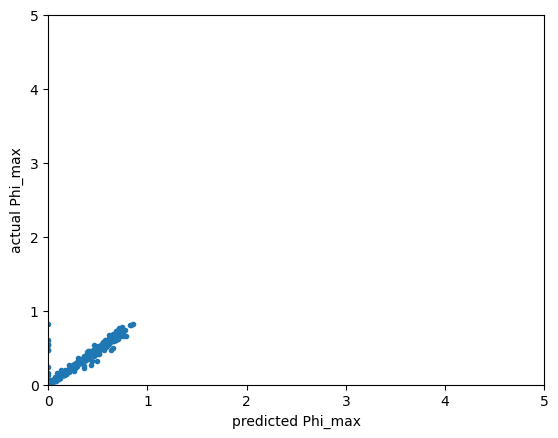

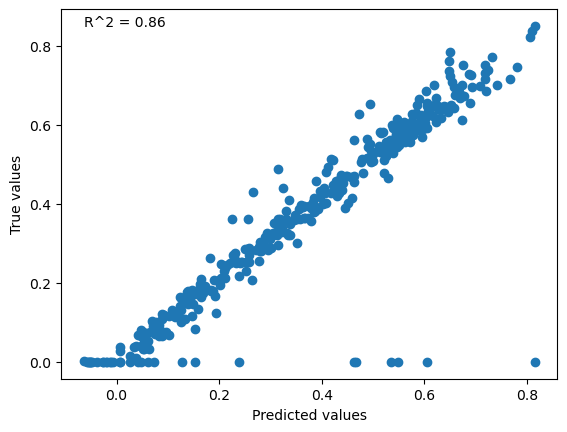

model_2 Neurons: 64
epoch: 0 loss: 0.22219569981098175
epoch: 100 loss: 0.023558208718895912
epoch: 200 loss: 0.006549128796905279
epoch: 300 loss: 0.022299014031887054
epoch: 400 loss: 0.001818872056901455
epoch: 500 loss: 0.0017890852177515626
epoch: 600 loss: 0.00306384707801044
epoch: 700 loss: 0.01327125821262598
epoch: 800 loss: 0.0007329310174100101
epoch: 900 loss: 0.005053927190601826
epoch: 1000 loss: 0.0005469940952025354


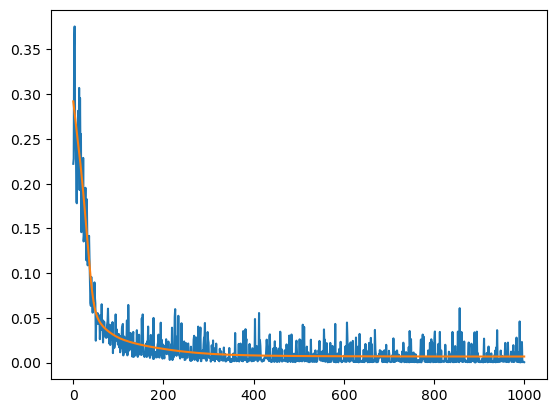

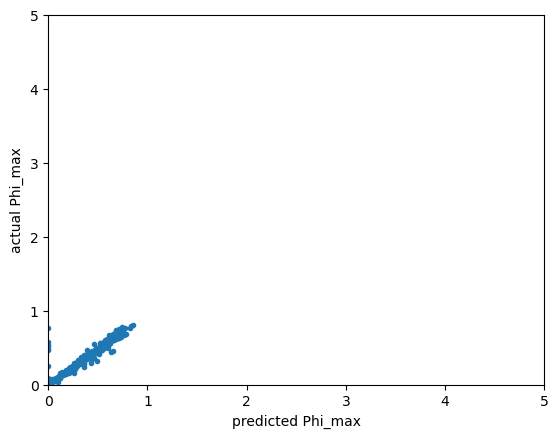

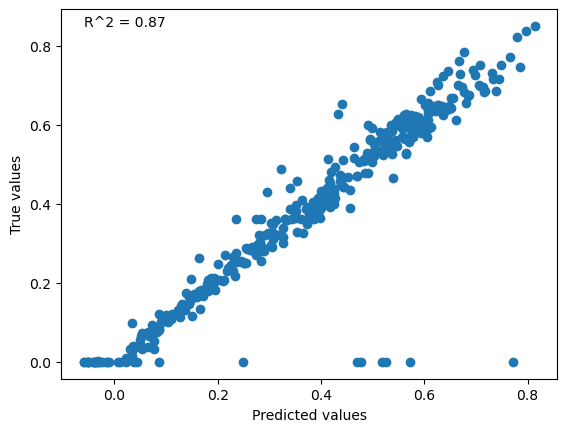

In [14]:
neurons_per_layer_list = [8, 16, 32, 64]
df_dict = {}
epochs = 1001
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
for neurons_per_layer in neurons_per_layer_list:
    models = [
              torch.nn.Sequential(torch.nn.Linear(7, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, 1)),
              
               torch.nn.Sequential(torch.nn.Linear(7, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, neurons_per_layer),
                                  torch.nn.ReLU(),
                                  torch.nn.Linear(neurons_per_layer, 1)),
    ]
             
    
    mses = []
    index = []
    for j, model in enumerate(models, 1):
        print('model_'+str(j), 'Neurons:', neurons_per_layer)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
        #optimizer = torch.optim.LBFGS(model.parameters())
        
        
        costval = []
        epoch_list = []
        
        # Hold the best model
        best_mse = np.inf   # init to infinity
        best_weights = None
        history = []
        
        for epoch in range(epochs):
            model.train()
            for i,(x_train, y_train) in enumerate(train_dataloader):
                
                #prediction
                y_pred = model(x_train)
                y_train = y_train.reshape(-1,1)
                #print(y_pred, y_train)

                #calculating loss
                loss = loss_fn(y_pred, y_train)
                #print(i, loss)

                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if epoch%100 == 0:
                print('epoch:', epoch, 'loss:', loss.item())
            costval.append(loss.item())
            epoch_list.append(epoch)
            
            model.eval()
            all_preds = []
            all_targets = []
            test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
            for i,(x_test, y_test) in enumerate(test_dataloader):
                y_pred = model(x_test)
                y_test = y_test.reshape(-1,1)
                mse = loss_fn(y_pred, y_test)
                
                
                if mse < best_mse:
                    best_mse = mse
                    best_weights = copy.deepcopy(model.state_dict())
                    best_y_test_actual = y_test.reshape(1,-1).detach().numpy()[0]
                    best_y_test_pred = y_pred.reshape(1,-1).detach().numpy()[0]
                    
                all_preds.append(y_pred)
                all_targets.append(y_test)
                    
            history.append(best_mse.item())
                
        pd.Series(costval, index=epoch_list).plot()
        
        pd.Series(history, index=epoch_list).plot()
        plt.show()
        
        pd.Series(best_y_test_pred, index=best_y_test_actual).plot(style='.', xlim=(0,5), ylim=(0,5), xlabel="predicted Phi_max", ylabel="actual Phi_max")
        plt.show()
        
        # Convert all_preds and all_targets to a single tensor
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        # Compute R^2 Score
        r2 = r2_score(all_targets.detach().numpy(), all_preds.detach().numpy())

        # Plotting the predicted vs true values
        plt.scatter(all_preds.detach().numpy(), all_targets.detach().numpy())
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        # plt.title('Predicted vs True values')
        # Adding R^2 text
        plt.text(min(all_preds.detach().numpy()), max(all_targets.detach().numpy()), f'R^2 = {r2:.2f}')
        # Save the figure
        #plt.savefig("predicted_vs_true.jpg")
        plt.show()

    #del(model)

In [18]:
best_weights

OrderedDict([('0.weight',
              tensor([[-0.2361, -0.1387,  0.3407, -0.0275,  0.1319, -0.3475, -0.1509],
                      [ 0.2772, -0.0902, -0.1511, -0.1017, -0.2741, -0.2596,  0.2470],
                      [-0.0140,  0.1454, -0.2486, -0.2809, -0.1355,  0.4051, -0.0614],
                      [-0.2636,  0.2805,  0.2821, -0.3172, -0.3214,  0.3537,  0.3202],
                      [ 0.0667,  0.1023,  0.2802,  0.2202,  0.2696, -0.0163,  0.4009],
                      [ 0.3009,  0.0618, -0.0566, -0.2214,  0.0998,  0.0260,  0.0994],
                      [-0.3530,  0.2012, -0.1179, -0.3373,  0.2341, -0.1594, -0.0369],
                      [-0.1936, -0.3663,  0.1915, -0.2663,  0.2786, -0.0515,  0.2492],
                      [-0.2493, -0.2821, -0.3406, -0.1914,  0.1942,  0.3210,  0.0457],
                      [ 0.2058,  0.1917,  0.0685,  0.2646,  0.0229,  0.2545,  0.2614],
                      [ 0.1489, -0.1077,  0.1533, -0.3161,  0.2928, -0.1046, -0.4187],
                 

In [271]:
model(x_test[1])

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

In [272]:
x_test[1]

tensor(0.6000)

In [105]:
type(torch.tensor(x0, dtype=torch.double))

torch.Tensor

In [130]:
x = np.array([torch.tensor(.5, dtype=torch.float32),
              torch.tensor(.6, dtype=torch.float32),
              torch.tensor(.7, dtype=torch.float32),
              torch.tensor(.8, dtype=torch.float32),
              torch.tensor(.9, dtype=torch.float32),
              torch.tensor(.1, dtype=torch.float32),
              torch.tensor(.2, dtype=torch.float32)])


#        X = np.array([(self.thicknesses[1, element] - self.de_thickness_mu) / self.de_thickness_std,
#                      (self.thicknesses[2,element] - self.fe_thickness_mu) / self.fe_thickness_std,
#                      (self.material_properties[0,element] - self.alpha_mu) / self.alpha_std,
#                      (self.material_properties[1,element] - self.beta_mu) / self.beta_std,
#                      (self.material_properties[2,element] - self.gamma_mu) / self.gamma_std,
#                      (self.material_properties[3,element] - self.g11_mu) / self.g11_std,
#                      (self.applied_voltage[element] - self.applied_voltage_mu) / self.applied_voltage_std])

#torch.tensor(self.thicknesses,dtype=torch.float32)
x_test = torch.tensor(x)
model(x_test)

tensor([0.2898], grad_fn=<AddBackward0>)

In [291]:
def rosen(x):
    x = np.array([torch.tensor(i, dtype=torch.float32) for i in x])
    x_test = torch.tensor(x)
    return np.abs(model(x_test).detach().numpy()[0])

In [304]:
np.std([1, 1.5, 2, 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6.0, 6.5, 7., 7.5, 8])

2.160246899469287

In [305]:
maximum = -np.inf
first = -2
last= 2.1
step = 0.5
print(np.arange(first,last,step))
for de_thickness in np.arange(-1.5,1.51,.5):
    for fe_thickness in np.arange(-4,4.1,1.):
        for alpha in np.arange(first,last,step):
            for beta in np.arange(first,last,step):
                for gamma in np.arange(first,last,step):
                    for g11 in np.arange(first,last,step):
                        for voltage in np.arange(first,last,step):
                            x0 = np.array([de_thickness, fe_thickness, alpha, beta, gamma, g11, voltage])
                            evaluated = rosen(x0)
                            if evaluated > maximum:
                                maximum = evaluated
                                print(maximum, x0)
print(maximum)

[-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]
0.3981675 [-1.5 -4.  -2.  -2.  -2.  -2.  -2. ]
0.42165747 [-1.5 -4.  -2.  -2.  -2.  -2.  -1.5]
0.45126644 [-1.5 -4.  -2.  -2.  -2.  -2.  -1. ]
0.49252355 [-1.5 -4.  -2.  -2.  -2.  -2.  -0.5]
0.5206718 [-1.5 -4.  -2.  -2.  -2.  -2.   0. ]
0.5466076 [-1.5 -4.  -2.  -2.  -2.  -2.   0.5]
0.5767018 [-1.5 -4.  -2.  -2.  -2.  -2.   1. ]
0.6008062 [-1.5 -4.  -2.  -2.  -2.  -2.   1.5]
0.60747963 [-1.5 -4.  -2.  -2.  -2.  -2.   2. ]
0.6090114 [-1.5 -4.  -2.  -2.  -2.  -1.5  1. ]
0.61700946 [-1.5 -4.  -2.  -2.  -2.  -1.5  1.5]
0.63484186 [-1.5 -4.  -2.  -2.  -2.  -1.   1. ]
0.6377525 [-1.5 -4.  -2.  -2.  -2.  -0.5  0.5]
0.64933324 [-1.5 -4.  -2.  -2.  -2.  -0.5  1. ]
0.6498101 [-1.5 -4.  -2.  -2.  -2.  -0.5  2. ]
0.65530086 [-1.5 -4.  -2.  -2.  -2.   0.   0.5]
0.6649601 [-1.5 -4.  -2.  -2.  -2.   0.   1. ]
0.6665525 [-1.5 -4.  -2.  -2.  -2.   0.   2. ]
0.6685289 [-1.5 -4.  -2.  -2.  -2.   0.5  1. ]
0.6836808 [-1.5 -4.  -2.  -2.  -2.   0.5  1.5]
0.689

In [297]:
maximum = -np.inf
first = -3
last= 3.1
step = 0.5
print(np.arange(first,last,step))
for de_thickness in np.arange(first,last,step):
    for fe_thickness in np.arange(first,last,step):
        for alpha in np.arange(first,last,step):
            for beta in np.arange(first,last,step):
                for gamma in np.arange(first,last,step):
                    for g11 in np.arange(first,last,step):
                        for voltage in np.arange(first,last,step):
                            x0 = np.array([de_thickness, fe_thickness, alpha, beta, gamma, g11, voltage])
                            evaluated = rosen(x0)
                            if evaluated > maximum:
                                maximum = evaluated
                                print(maximum, x0)
print(maximum)

[-3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.   2.5  3. ]
0.6035841 [-3. -3. -3. -3. -3. -3. -3.]
0.6229632 [-3.  -3.  -3.  -3.  -3.  -3.  -2.5]
0.6300951 [-3. -3. -3. -3. -3. -3. -2.]
0.6546421 [-3.  -3.  -3.  -3.  -3.  -3.  -1.5]
0.6873957 [-3. -3. -3. -3. -3. -3. -1.]
0.70504266 [-3.  -3.  -3.  -3.  -3.  -3.  -0.5]
0.7065329 [-3.  -3.  -3.  -3.  -3.  -3.   0.5]
0.7090219 [-3. -3. -3. -3. -3. -3.  1.]
0.7186195 [-3. -3. -3. -3. -3. -2.  0.]
0.735182 [-3.  -3.  -3.  -3.  -3.  -1.5  0. ]
0.74846166 [-3.  -3.  -3.  -3.  -3.  -1.5  0.5]
0.7506604 [-3. -3. -3. -3.  2.  0.  3.]
0.75137764 [-3.  -3.  -3.  -3.   2.   0.5  3. ]
0.7550128 [-3.  -3.  -3.  -3.   2.5  0.   2.5]
0.7669829 [-3.  -3.  -3.  -3.   2.5  0.   3. ]
0.7766647 [-3.  -3.  -3.  -3.   2.5  0.5  3. ]
0.7825766 [-3. -3. -3. -3.  3.  0.  3.]
0.8000143 [-3.  -3.  -3.  -3.   3.   0.5  3. ]
0.8096795 [-3.  1. -3. -3. -3. -2.  3.]
0.8236062 [-3.   1.5 -3.  -3.  -3.  -2.   3. ]
0.8288495 [-3.   1.5 -3.  -3.  -3.  -1.5  3. ]


In [275]:
x0 = np.array([-0.1187, -0.8883, -1.2639,  1.9293,  1.6645, -0.6675, -0.9797])
rosen(x0)

2336.516817690388

In [269]:
x0 = np.array([-0.1187, -0.8883, -1.2639,  1.9293,  1.6645, -0.6675, -0.9797])

In [257]:
x0 = np.array([0, 0, 0, 0,  0, 0, 0])

In [267]:
rosen(np.array([0.99951595, 0.99949881, 0.99936711, 0.99926563, 0.9984203 ,
       0.9968683 , 0.99377963]))

7.875490518568738e-05

In [264]:
from scipy.optimize import minimize, rosen, rosen_der
res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-12)#, jac=rosen_der)

In [265]:
res.x

array([0.99951595, 0.99949881, 0.99936711, 0.99926563, 0.9984203 ,
       0.9968683 , 0.99377963])

In [260]:
res = minimize(rosen, x0, method='Nelder-Mead', 
               options={'gtol': 1e-12, 'disp': True})

/tmp/ipykernel_1923144/3358881407.py:1: OptimizeWarning: Unknown solver options: gtol
  res = minimize(rosen, x0, method='Nelder-Mead',
/tmp/ipykernel_1923144/3358881407.py:1: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(rosen, x0, method='Nelder-Mead',


In [261]:
res.x

array([0.99951595, 0.99949881, 0.99936711, 0.99926563, 0.9984203 ,
       0.9968683 , 0.99377963])

In [67]:
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[-0.2395, -0.1398,  0.3400, -0.0271,  0.1324, -0.3450, -0.1423],
        [ 0.2788, -0.0878, -0.1517, -0.1020, -0.2738, -0.2585,  0.2466],
        [-0.0163,  0.1407, -0.2502, -0.2808, -0.1344,  0.4032, -0.0620],
        [-0.2626,  0.2824,  0.2809, -0.3164, -0.3205,  0.3503,  0.3231],
        [ 0.0641,  0.1037,  0.2818,  0.2179,  0.2675, -0.0162,  0.4047],
        [ 0.3040,  0.0594, -0.0533, -0.2234,  0.0971,  0.0265,  0.0904],
        [-0.3512,  0.2016, -0.1173, -0.3371,  0.2340, -0.1574, -0.0444],
        [-0.1899, -0.3675,  0.1934, -0.2677,  0.2770, -0.0472,  0.2393],
        [-0.2448, -0.2839, -0.3379, -0.1931,  0.1919,  0.3188,  0.0458],
        [ 0.1994,  0.1953,  0.0657,  0.2686,  0.0262,  0.2544,  0.2630],
        [ 0.1465, -0.1075,  0.1531, -0.3153,  0.2932, -0.1014, -0.4169],
        [ 0.2657, -0.1752,  0.3834, -0.3083,  0.2720,  0.0698,  0.0827],
        [-0.0473, -0.2513, -0.1997, -0.1249,  0.2358,  0.2813,  0.1733],
        [ 0.3538,  0.1264, -0

In [68]:
import numpy as np
from scipy.optimize import minimize

In [119]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam([var1, var2], lr=0.0001)